In [2]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))


In [132]:
filepath = 'C:/dev/csb-net/extracted/reCurse/2843387/frames_reCurse_2843387.csv'

import math
import numpy as np
import pandas as pd

df = pd.read_csv(filepath, index_col=False)
print('Columns:', df.columns)
#df.describe()
# df.head()

def augment(df, orig_data, dx, dy):
    x_cols = ['p1x', 'p2x', 'p3x', 'p4x', 'p1wx', 'p2wx', 'p3wx', 'p4wx']
    y_cols = ['p1y', 'p2y', 'p3y', 'p4y', 'p1wy', 'p2wy', 'p3wy', 'p4wy']
    translated = df2.copy()
#     print('translated\n', translated.head())
    translated.loc[:, x_cols] += dx
    translated.loc[:, y_cols] += dy
    print(dx, dy, df.shape)
#     print('translated\n', translated.head())
    return pd.concat([df, translated])

# print(df.shape)
# print(df.tail())

orig_data = df.copy()

# The walrus operator is new in python 3.8 
# [df := augment(df, orig_data, dx, dy) for dx in range(-150, 150, 100) for dy in range(-150, 150, 100)] 

print(df.shape)
print(df.tail())

y = pd.concat([df.pop(x) for x in ['p1tx', 'p1ty', 'p1t', 'p2tx', 'p2ty', 'p2t']], 1)
X = df
print(y.head())

from sklearn import preprocessing

y[['p1tx', 'p1ty']] = preprocessing.normalize(y[['p1tx', 'p1ty']], norm='l2')
y[['p2tx', 'p2ty']] = preprocessing.normalize(y[['p2tx', 'p2ty']], norm='l2')

print(y.head())
# print(X.head())


Columns: Index(['p1x', 'p1y', 'p1sx', 'p1sy', 'p1a', 'p1wx', 'p1wy', 'tf1', 'pf1',
       'p2x', 'p2y', 'p2sx', 'p2sy', 'p2a', 'p2wx', 'p2wy', 'tf2', 'pf2',
       'p3x', 'p3y', 'p3sx', 'p3sy', 'p3a', 'p3wx', 'p3wy', 'tf3', 'pf3',
       'p4x', 'p4y', 'p4sx', 'p4sy', 'p4a', 'p4wx', 'p4wy', 'tf4', 'pf4',
       'p1tx', 'p1ty', 'p1t', 'p2tx', 'p2ty', 'p2t'],
      dtype='object')
(38008, 42)
         p1x   p1y  p1sx  p1sy  p1a   p1wx  p1wy  tf1  pf1    p2x  ...   p4wx  \
38003  12076  3506   458   502   23  12452  1326    0    0  10844  ...  13557   
38004  12566  4011   416   429    5  12452  1326    0    0  10722  ...  13557   
38005  13013  4433   380   358  -13  12452  1326    0    0  10643  ...  13557   
38006  13420  4775   346   290  -31  12452  1326    0    0  10605  ...  13557   
38007  13787  5041   311   225  -49  12452  1326    0    0  10606  ...  13557   

       p4wy  tf4  pf4   p1tx   p1ty  p1t    p2tx   p2ty  p2t  
38003  7627    1    0 -88236  -1244  200  103704  40259  

In [133]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f'Train data contains {X_train.shape[0]} sample')
print(f'Test  data contains {X_test.shape[0]} sample')

Train data contains 30406 sample
Test  data contains 7602 sample


In [134]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc_inputs = StandardScaler()
X_train_std = sc_inputs.fit_transform(X_train)
X_test_std = sc_inputs.transform(X_test)

# sc_outputs = StandardScaler()
sc_outputs = MinMaxScaler(feature_range = (-1, 1))
y_train_std = sc_outputs.fit_transform(y_train)
y_test_std = sc_outputs.transform(y_test)

print(y_train)
print(y_train_std)

X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(X_train_std, y_train_std, test_size=0.1, random_state=1)

           p1tx      p1ty  p1t      p2tx      p2ty  p2t
30348 -0.414031 -0.910263  200 -0.998295 -0.058372  200
28013 -0.074992 -0.997184  200  0.553733  0.832694    0
26266 -0.383136  0.923692  200  0.676393  0.736541    0
4427   0.146680 -0.989184  200 -0.313114 -0.949715    0
20393 -0.629619  0.776904  200 -0.467094  0.884208  200
...         ...       ...  ...       ...       ...  ...
7813   0.708946  0.705263  200 -0.136169  0.990686  200
32511 -0.688639 -0.725104  200  0.667356  0.744739    0
5192  -0.902108 -0.431511  200 -0.522885 -0.852403  200
12172 -0.874510  0.485007  200  0.310776  0.950483    0
33003 -0.160225  0.987080  200  0.735575 -0.677444  200

[30406 rows x 6 columns]
[[-0.41 -0.91  1.   -1.   -0.06  1.  ]
 [-0.07 -1.    1.    0.55  0.83 -1.  ]
 [-0.38  0.92  1.    0.68  0.74 -1.  ]
 ...
 [-0.9  -0.43  1.   -0.52 -0.85  1.  ]
 [-0.87  0.49  1.    0.31  0.95 -1.  ]
 [-0.16  0.99  1.    0.74 -0.68  1.  ]]


In [128]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [135]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
import math

model = keras.Sequential([
    layers.InputLayer(input_shape=(X_train_std.shape[1], )),
    layers.Dense(40, activation='relu', activity_regularizer=l2(0.01)),
    layers.Dropout(0.2),
#     layers.Dense(30, activation='relu', activity_regularizer=l2(0.01)),
#     layers.Dropout(0.2),
#     layers.Dense(20, activation='relu', activity_regularizer=l2(0.01)),
#     layers.Dropout(0.2),
    layers.Dense(20, activation='relu', activity_regularizer=l2(0.01)),
    layers.Dense(6, activation='linear')
])

import tensorflow.keras.backend as K

np.set_printoptions(precision=2)

def customLoss():
    def combined_loss(y_true,y_pred):
        p1x_loss = K.square(y_pred[:, 0] - y_true[:, 0])
        p1y_loss = K.square(y_pred[:, 1] - y_true[:, 1])
#         p1t_loss = K.square(y_pred[:, 2] - y_true[:, 2])
        p2x_loss = K.square(y_pred[:, 3] - y_true[:, 3])
        p2y_loss = K.square(y_pred[:, 4] - y_true[:, 4])
#         p2t_loss = K.square(y_pred[:, 5] - y_true[:, 5])

        p1t_pred = y_pred[:, 2].numpy()
        p1t_pred[p1t_pred < 0] = -1
        p1t_pred[p1t_pred > 0] = 1
        p1t_loss = K.square(p1t_pred - y_true[:, 2])

        p2t_pred = y_pred[:, 5].numpy()
        p2t_pred[p2t_pred < 0] = -1
        p2t_pred[p2t_pred > 0] = 1
        p2t_loss = K.square(p2t_pred - y_true[:, 5])

        loss = p1x_loss + p1y_loss + p1t_loss + p2x_loss + p2y_loss + p2t_loss 
#         print(f'Custom loss: {loss[0]} ({p1x_loss[0]} {p1y_loss[0]} {p1t_loss[0]} / {p2x_loss[0]} {p2y_loss[0]} {p2t_loss[0]})')

        return loss 
    return combined_loss

model.summary()
model.compile(loss='mse', optimizer='adam')
# model.compile(loss=customLoss(), optimizer='adam')
# model.run_eagerly = True

# Eager execution is on by default
# tf.executing_eagerly()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 40)                1480      
_________________________________________________________________
dropout_44 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 20)                820       
_________________________________________________________________
dense_110 (Dense)            (None, 6)                 126       
Total params: 2,426
Trainable params: 2,426
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
845/856 [============================>.] - ETA: 0s - loss: 0.6798
Epoch 00001: val_loss improved from inf to 0.55744, saving model to csb_best_model.h5
856/856 [==============================] - 3s 4ms/step - loss: 0.6785 - val_loss: 0.5574
Epoch 2/50
841/856 [============================>.] - ETA: 0s - loss: 0.5272
Epoch 00002: val_loss improved from 0.55744 to 0.47051, saving model to csb_best_model.h5
856/856 [==============================] - 2s 3ms/step - loss: 0.5266 - val_loss: 0.4705
Epoch 3/50
840/856 [============================>.] - ETA: 0s - loss: 0.4740
Epoch 00003: val_loss improved from 0.47051 to 0.43306, saving model to csb_best_model.h5
856/856 [==============================] - 3s 3ms/step - loss: 0.4736 - val_loss: 0.4331
Epoch 4/50
854/856 [============================>.] - ETA: 0s - loss: 0.4510
Epoch 00004: val_loss improved from 0.43306 to 0.41714, saving model to csb_best_model.h5
856/856 [==============================] - 3s 3ms/step - loss: 0.4511

<Figure size 720x432 with 0 Axes>

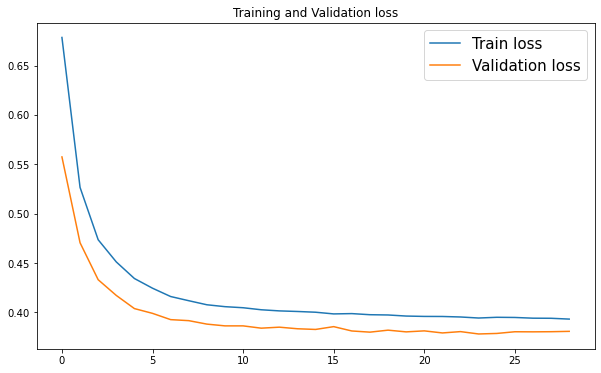

<Figure size 720x432 with 0 Axes>

In [136]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('csb_best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

history = model.fit(X_train_std, y_train_std, validation_data=(X_val_std, y_val_std), epochs=50, callbacks=[es, mc])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
plt.title ('Training and Validation loss')
plt.figure()

# plt.plot  ( epochs[1:],     loss[1:] )
# plt.plot  ( epochs[1:], val_loss[1:] )
# plt.title ('Training and Validation loss')

<Figure size 720x432 with 0 Axes>

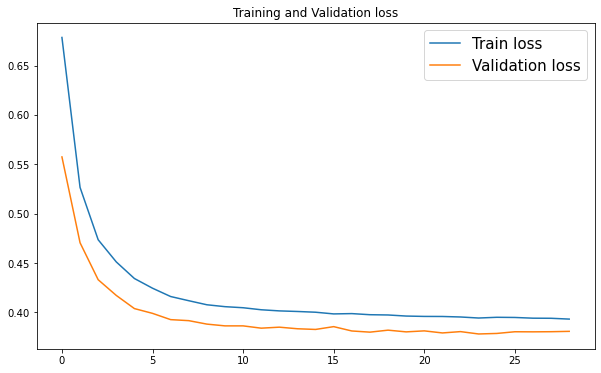

<Figure size 720x432 with 0 Axes>

In [137]:
from tensorflow.keras.models import load_model
model = load_model('csb_best_model.h5')

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
plt.title ('Training and Validation loss')
plt.figure()

<Figure size 360x216 with 0 Axes>

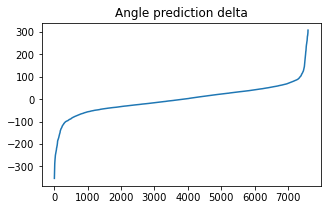

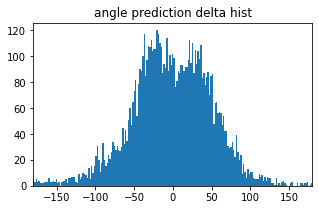

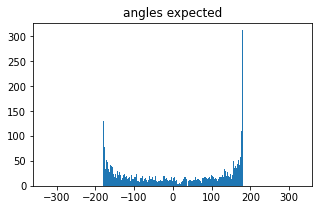

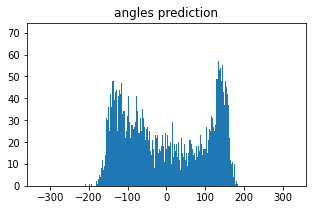

<Figure size 360x216 with 0 Axes>

In [139]:
from numpy import array, sort

p_all = model.predict(np.array(X_test_std))

predicted = []
deltas = []
outputs = []
for idx, input in enumerate(X_test_std):
    target = y_test_std[idx]
    p = p_all[idx]
        
    delta = (p[0] - target[0])*180
    deltas.append(delta)
    
    predicted.append(p[0] * 180)
    outputs.append(target[0] * 180)
    #print ('predicted angle delta', f'{delta}')
    #print()
    #print(int(p[0] * 180))
    #print(int(p[1] * 200))
    #print(int(p[3] * 1000))
    #print(int(p[4] * 1000))
    #print(int(p[5] * 200))
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3]

epochs   = range(len(deltas)) # Get number of epochs

deltas = sort(deltas)
plt.plot(epochs, deltas)
plt.title('Angle prediction delta')
plt.figure()

plt.hist(deltas, bins = 360)
plt.title('angle prediction delta hist')
plt.xlim(-180, 180)
plt.figure()

plt.hist(outputs, bins = 360)
plt.title('angles expected')
plt.xlim(-360, 360)
plt.figure()

plt.hist(predicted, bins = 360)
plt.title('angles prediction')
plt.xlim(-360, 360)
plt.figure()


In [87]:
y_test_pred_std = model.predict(X_test_std)

y_test_pred = sc_outputs.inverse_transform(y_test_pred_std)

delta = y_test - y_test_pred
print(y_test)
print(y_test_pred)
print(delta)

         p1tx    p1ty  p1t   p2tx    p2ty  p2t
12970  -49844   84861  200 -68361  -64256    0
9730   -19269  100661    0  80077  -60858  200
23237  105569   -5428  200  45609  -92328  200
17497  -88991   -5251  200  14858  106818  200
14497   46134  100491    0 -68085  -64840  200
...       ...     ...  ...    ...     ...  ...
4670   -91747   18378    0 -70959   68242    0
34365  -92243   -6084    0 -19848   96221    0
35463  103657    6907    0 -83805  -43621    0
36388   -8389  -94123    0 -28735   98189  200
24477  108995   20520  200 -15240  104917    0

[7602 rows x 6 columns]
[[  7724.3276    90689.79        134.88667   11519.677      6901.3735
     113.18966 ]
 [ 44567.965     81534.75        137.75555   15256.5625     4743.242
     111.98074 ]
 [ 77702.04     -25686.588       151.08966   18732.734     -4936.706
     116.5874  ]
 ...
 [ 76856.97     -26885.38        151.05107   18620.295     -4936.758
     116.594574]
 [ 27261.723    -74893.414       139.58192    9335.278     -2

In [78]:
print(y_test_pred[0])
print(y_test.iloc[0,:])

[-59890.98     66033.42       142.58134 -49680.047   -63080.
    115.31177]
p1tx   -49844
p1ty    84861
p1t       200
p2tx   -68361
p2ty   -64256
p2t         0
Name: 12970, dtype: int64


In [62]:
i = 1

printmd('**input**')

p = frames[i].pods[0].position
print('pos:', int(p.x * 16000), int(p.y * 9000))

s = frames[i].pods[0].speed
print('speed:', int(s.x * (650 + 200)), int(s.y * (650 + 200)))

a = frames[i].pods[0].angle
print('angle:', int(a * 180))

w = frames[i].pods[0].waypoint
print('waypoint:', int(w.x * 16000), int(w.y * 9000))

printmd('**output**')

t = frames[i].actions[0].aim
print('aim:', int(t.x * 1000), int(t.y * 1000))
#print('aim abs:', int(p.x * 16000) + int(t.x * 1000), int(p.y * 9000) + int(t.y * 1000))
pw = frames[i].actions[0].power
print(int(pw * 200))

t = frames[i].actions[1].aim
print('aim:', int(t.x * 1000), int(t.y * 1000))
#print('aim abs:', int(p.x * 16000) + int(t.x * 1000), int(p.y * 9000) + int(t.y * 1000))
pw = frames[i].actions[1].power
print(int(pw * 200))

printmd('**prediction**')

p = model.predict(np.array(inputs)[i:i + 1])
bot = p[0]
print(bot)
print(int(bot[0] * 1000))
print(int(bot[1] * 1000))
print(int(bot[2] * 200))
print(int(bot[3] * 1000))
print(int(bot[4] * 1000))
print(int(bot[5] * 200))

**input**

NameError: name 'frames' is not defined

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                750       
_________________________________________________________________
dense_7 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 44        
Total params: 2,044
Trainable params: 2,044
Non-trainable params: 0
_________________________________________________________________


In [27]:
import pickle

a = [x.get_weights() for x in model.layers]

#a = model.layers[0].get_weights()
serialized = pickle.dumps(a, protocol=0) # protocol 0 is printable ASCII

print(serialized)


#for layer in model.layers:
#    print(layer.get_weights())


b'(lp0\n(lp1\ncnumpy.core.multiarray\n_reconstruct\np2\n(cnumpy\nndarray\np3\n(I0\ntp4\nc_codecs\nencode\np5\n(Vb\np6\nVlatin1\np7\ntp8\nRp9\ntp10\nRp11\n(I1\n(I28\nI30\ntp12\ncnumpy\ndtype\np13\n(Vf4\np14\nI0\nI1\ntp15\nRp16\n(I3\nV<\np17\nNNNI-1\nI-1\nI0\ntp18\nbI00\ng5\n(V\\u000a"@>\x18&\xd2=M\\u0000\xb7=M\x1b=\xbd\x94\x92 \xbe\xf0\x91\xe3\xbd#\x87\'>\x8b7\x91>\xfc\x0fP\xbcWX\x98=Z\x0b6\xbf\xb0P\x89<\x11B\xa4;K\xb1#=#B\x1c\xbe\x9e$\x19\xbf\x10\xf7\xa5=\xf2\x12\x1d<q"i=\xdf"\x84>\x8e4?\xbd3\xea\xb8<E\xdfh\xbb\x1d\x83\xf7=\x8d\x1dH\xbe\xa4\x04l>\xe3\x99><\xa9F\t;Dgq\xbe\xb28\\u001a\xbe\x91I\x8f\xbdS\xc1\x80>+9\x9b=\xa4>X\xbe\\u000a\xeec\xbc\x95\xbf\xb2\xbd\xca\xfb6>\xdd|\x11\xbe\x89h\xf0\xbd\xbe\x14\xb0\xbd\x8f\xd6\x81\xbejh;\xbc\xa9N\x04\xbe\x8c>/\xbe\xb0\xfdb\xbeva\xd0\xbe$\x80\xfe\xbdi\xac\x83\xbcd[\x07=n\x05\x03=\x97\x89\x1d=\xf0+\xc8\xbd\x9d\x84:>\x03(Y>\xcf\xdd\x97\xbe\xdb\x1f\x81>\x84\x9a\x0b>J\x18\x04\xbdx\x1e\'>u\xc1x\xbd\xf3\x9f\xf3=-[\x86=\xecG\xe1=\x95\x0e\x06>\xa5\xb1\x96

In [31]:
data = b'(lp0\n(lp1\ncnumpy.core.multiarray\n_reconstruct\np2\n(cnumpy\nndarray\np3\n(I0\ntp4\nc_codecs\nencode\np5\n(Vb\np6\nVlatin1\np7\ntp8\nRp9\ntp10\nRp11\n(I1\n(I28\nI20\ntp12\ncnumpy\ndtype\np13\n(Vf4\np14\nI0\nI1\ntp15\nRp16\n(I3\nV<\np17\nNNNI-1\nI-1\nI0\ntp18\nbI00\ng5\n(V\xf1\xe80\xbf\x0e\xb2\x9a?\xfd\xea\xa8=\x9a\xec\x89?\xc1\xd6\x06\xbe},>@\xa2p,\xbd<\xc3\x80\xbd\xb2\x11\\u0000\xbf\xe2\x8fI\xbeq\xc4\x98\xbe\xc8gK>]9\t?\xeaS\xe2>\xf9\xdb\x81\xbe\xd1(3<\x80\xe2a\xbc4\xf14\xbe\xde;\x9b\xbd\xd3$\x16\xbfQy\xdf>}D\xe2>?M\xb9>\xf3_\x88<W\xd9\\u0000\xbd\xe1U\xd9=\xd3\x02\x9c>\xee\x1c\xd4<D\xe5/\xbf\x08\x8c\xb7\xbd\xbb4\x18\xbd\xcb\xa7Z\xbe\'i\xb4\xbe\xe8^\x8f>0\x86_\xbe\xb1n\x18>\xe7\xc2\x9d\xbd\x81M.\xbe\xaa\xf0d\xbc\x84\\u001a,\xbfp\x15\xde\xbdV\xff\xee>"\xb8\\u000a?\x80\xea\x9d\xbfs_\xdf\xbdP\xd4F\xc0\xf7v4\xbe\xff\xc4\x9a>\x91\x1f[>\x08\xd8 =\x87\xd2\x10>\tt\x91<\xd0\x15\xa3>\x97$Q\xbf\xd0\xc6)\xbf\x90\xb2k\xbdh1b\xbe\x05\\u005cl>\xcd\x04\x88\xbeX\xd9\xde\xbc\x7f\xa3\x02\xbfT\xccw\xbd1\x88\x8f>\x95\xc5\xca>)\x86\x82=Q\\u005c\x03\xbfu\x14\x8b=rJ*>\xb9\xad\x86\xbe_+\xd4<\xcf8\x8d=\x1b"\x14>\xf9\xb8+\xbfG\xe9\xa4=\xce\xb9e\xbe~\xa3,\xbe\x93\xc6\x0f?&\xcb\x04?\xd5\x0e\xce>\x8e\x88T\xbe\x02\xe0\xb0?_=0?\xca\x07\xa2\xbfh\xcfa>$\xc3\x13\xbe\\u001a\xb2\x92\xben\xe2d\xbb\xd3\xb4\x80?p\xe5\xfa\xbd\xf1\x9eh\xbd\xd5\xe0\xa6>\xdeT\xbe\xbdk:B\xc0D8\xe4>\xcfoI\xbfp(W=Y&\xa4\xc0\xa9M\xa5\xc0o\xab\xb5\xbf\xfdN\x08\xc0oI9?\x0eT\x14>V\xd9\xbb>\x16\x9d\xc0\xbeM\xba\x8e\xbe\xb5\xc5\x9e\xbf\x9e\xf1 \xbc\xe4\x8eG\xbfi2\xc6>\x17\xeaB\xbe\xfaF\x96>q\x81\x83\xbe\x13\xddL\xbfJyU\xbeyW\x18>\xed\xfa\x86==\xe8\x11>f\x9fC>X1_\xbe\x18\\u0000\xbc>T\x9b>>\xb3~[>EkG\xbe\x9b \xc2>\x98\xa5\x93\xbeCp\x9d=\x87d\xb1\xbd\xbd\xef\x8d=i\xa3\xc8>\xbd\xde\xe8\xbd\xc8J \xbehE\x83\xbe?\xae\x1b==\xf0+\xbf\x89\x06\\u001a>\xceS\xf9>X|\x91=\x7f\x9d\x98<\x8a\x182>fz\x1d?\x92\xf8\xbe=/&#?\xcd$K\xbd\xd0\x89\xcd\xbe\x8f\xcb\x7f\xbd\x07\x8c\x03?\\u000d\xf9\x06?cj\x9e\xbeN\xea4\xbf\xe0\xd6\xa4\xbey\x9c\xbf\xbd\xd1\xce\xc3=\\u000az\x11\xbe\x0cy\\u000a\xbf\xd6\xb8\x0b>\xb5\xaaD\xbe\xf0\xd7L>\x1e\x96w=\xccR&?p"\x8a\xbe\xf8\x15W?\\u005c\xcfI\xbeT\x1eH>~\x10:?\xf8\x95z=\xcam\x04\xbd\x1e\x11!>h\x8b\xbb=1+*>k\xb2Z\xbd\xb4\x80M=,\xc4\xcc\xbe\xf6Xc\xbc\xf8"\x12\xbcn\xa6c>\xaeP\xbd=\xea4Q\xbd\xdeL\x93\xbd\xc2\x06P>{T\xb3\xbbT/\xd2>\x0c\xcaQ>\xdd\x10n>\xd2\xc4\xa3>UU#?\xde\x0e\x0e>h\xac\xfd>\xb5,r\xbe\xcd\xb2\xd3>\xe7\xd3\xc3>9UV\xbe\xde\xb7\x02>3S>\xbevX\xec\xbc\x9c\\u000d\x86=X<O\xbfiN\xa6=\xde\x04\xa7=uL\xda\xbc\xb4H\xa7\xbd\xe3\x8d\x83=\x9e\x87\xfd\xbd\xc4O\x08\xbdA\xe2\xd6\xbe\xaa\xa2\x87\xbe\xafe\x10?7\xcc\xc4\xbc\x11m\xb8=o t\xbf\xbdC\xf6\xbe\x15/\xa8\xbe\xb0v\x96>$\x88\x9b>b\xc8\x85\xbd\xce\x14\x01\xbe\x07\x0f{\xbe!X\xd9<\x17\xf2\x01<X}\xff=3\x9d1>,\xa3\xaf>\xf0\xdd$>\x18\x87&?\xe4\xe5\x1d\xbcs\x18\xae\xc0\xb4\xb0\\u0000?\xbb\xb5\xc3@1\x93P?8\x86\xa0@\x11]\xb2@nL\xf3\xbf\xa7N_@\x90\xa7B=^\xf0\x89\xbf\x1f\x98T?\x03\x1f\xe6@\xc7\xad\xd4\xbd\x89\x98\'\xbdeD\x81\xbeWw@\xbd..\xd6>\x82Y\x96=\x8fC\xa6>\x9a\xa5y>],w=\\u000d\x12\x1e>\xc7\xe9\xbe\xbda\xcb:>:\xea8>g\x05U>\xceG\x11>u\xcfJ\xbe\xec\x88\xf9\xbd\xd2O\xe8=\xb2\xf4\xb9<\x06\xb09?\xd8\xaa\xdb\xbd\xca%\xc6\xbd=\xdb\x9f\xbd\x98\xef\xf0=%\x1fo=\x18+\xb7>\\u000a\xce\xa7\xbd13\xc4>\x15{3\xbd7\xd0\xba>\xccQ\x82\xbd$\x1e\x14>z\xfc\xd2>[E\xc1=\x125@>7 T\xbe\x92D\xab\xbe"\x07E\xbe\xb7#\xc6>S\xf6\xb8>\xb5\xff\x1b\xbd\x06\xeb\xd8\xbc\xfe\x07\xa0\xbc\xfd\xd5\x0f\xbd\xfe\xf9\x19;\x94\xf3\xe2<(\xb5\x90\xbe:\x86t>\x94\xcbH\xbe\x99\x18 ?\x05\xbdE=y\xb7+<\xc1?\x9e\xbe:F\x1c\xbd\x94\x8d\x85>\xc3H\x8b=\\u0000A{\xbe\xe9\x916>\xd4\xeb\xc4=o\x9e\xd2<-\xeb\xa4\xbd\xeb\xee\x88\xbc*\xce\xd8\xbd\xf48\xa9>\xd2u\xb6\xbe\x99\xdd ?\xdb\xeb\x83\xbc\x95 \x96\xbe||\'\xbe\xab\x03(>\xa9\x0f\x81\xbe\xc2\t\xa6\xbd\x7f\x10\x82\xbd\xa8\xf2\xa5\xbdd\x1eY\xbe\xcb\xefs>o\xd5\x87\xbe;\xb7n\xbe\xc3\xd2\xa2\xbe\xa5L\xb0<\xf7(\x04>a\xf4\x87=A\xe4\x86>7\xcd\x10\xbdq%\xe2\xbd7Mu\xbd\x8b\x8dn=\xbe\xc4\x86\xbe\xbf\xf7\x08\xbe(=\xf4\xbe\xf2n\x18\xbe\xf6\xc6t=\x14\xf8F\xbe\x9d\x12\xeb\xbd\x13\x93\xce\xbe\xdc\xa3\x05\xbe\x17hj\xbd\xdeC\xe0\xbd\xfa\x08\x9f\xbe/\x9aS>y\xbc|=\x15\xb6V\xbb\xf3E\\u000d\xbd\xef\xad\x8e>g\x85\x12\xbf\x18<v?\x96(\x94>\xd7p\'\xbf\x908\\u001a\xbe\x10{\x1d\xbfB\x1e\x9f\xbd\x96\xa6\x12\xbe\xaf\xf6,?\x84i\\u001a\xbeYi\\u005c\xbf\xe8\xcb\xf6\xbc\xd8\x83\xb5\xbd\x8f{\xee\xbe.@\xdc\xbeSv\x7f\xbe\xafN?\xbd\xa5\xe8\x13\xbd\x93\xeb\x16\xbf\xe7u:>\xbc \xca\xbd\xd3{\xab\xbbq\xe6\x97\xbdsm\xb9\xbdZ\\u005c\x93<%\x0b\x8f>\xf3\x8a\t\xbd3:\xbc<\xbc\x82c\xbdI0m<w\x8ab>\x8f\xc3\xdd=o\xc2\x9c\xbc\xdbX(=\xf9I\xae=\x8f\\u005cB<\xd0\x8b\x94\xbb\xca\x8d\x88<@9\'>\xa1?%\xbe\x7f\xb5\xc5\xbd\xc57\xf0>|J\xb8<\xa1%{?h\xc0\xa4\xbe\x13?\x9e\xbc\xab\x18\xc3\xbe\x8e\xff/\xbe\xa5\x82v?\xa5]\'\xbe 3\xdb\xbe\xfe\xa5\\u0000\xbe.\xad\xcb\xbeU\x90\x01\xbfo1\x9a\xbe=p\xa2=\xb2Y\x11>\x98\xc4\x07<k\xae\x1b\xbe\x8e\xd3\x9b>\xf8\x8ar\xbdKR\\u000a>\x158#\xbe\xa6\xd8\xf2>\xaf\x8a\xca\xbe\x10\xd5\xd4>-\x11>\xbes\x8c\xd2\xbec\\u000a3\xbe8\\u000aJ\xbel\xe0\xc1>$7\xe9=\x02\x05K\xbe\x96\x88i\xbe\x90?\x8e<\x0fF\x8a>\xba\x03\xe9=|N\xf0<D\x86->\xf3\xd7+<\xe8N(>7\xe6H\xbeG\xbet\xbe\xb7\xfb<>Z"\xc0\xbdo\xafO\xbe=V\x81\xbd\x88C\x86\xbdC\xfc2\xbd\xc4XF\xbd\xfb]o\xbe`\xe8\x9c\xbd\xd5\xdfn\xbdQ\x96\xd1\xbdk\\u001a\x80=\xa3\\u0000\x15>\x93(c\xbc\x1b?\xb0<\x14\xf6\xa1\xbe\xf5;\xb8>\\u000dk\xf2\xbd\xa6\xad\xb4>\xa9\xef\xb6\xbe6G\xe7>K\x97<\xbe\xc8\x9bD>\x0el\x01\xbe\xe7q\x1b\xbd3\xf6\x01?U\x97\xf6\xbd\xf0\x98\xa4\xbd\xbf\xd8D>\x08\x7f\xa5\xbc\'\xea\x16\xbf\x95\x93#\xbd#\xd3T>9\xa5\x0f>\x1e\xe4\x9d<\xce\xcc\xe0\xbc\xb3\x92\xcb>h\xd14\xbe"\xe1G\xbe\xd5\x0c\xa4>\x1d\xf3\xea\xbe~8E\xbd\xcd\xc1\x83\xbfv\x11K=\xb0\xa5E>|\x9aG\xbeJ\xa2\xd4;)Ca?S\x04w>\xc4J\x9a=\x11\xbc\xaf=\xae\xa4@\xbe\x98\x8d\xf1\xbc\xfb\xd2\xa5\xbcv\xb4Y\xbbc\xc3_\xbe\xf2N\xd2\xbd\xcf\x05R\xbe!\xafT>\xdcb\xbe>i*\x97=\xfe\x02\xd6=\xde\x8f]>\x11|I;\xf8Y\xf5=\x94\xe0\x84\xbexA\x1d>`\\u000a\xe1>6\x90k\xbd\x11?\x06<q\xf2\x9a>C\xd2\x02\xbeSo\x16>\x91\x03\x11<{"|\xbdD\\u001a\xcf\xbe\xdac|\xbd\xddD\x9e\xbd>\xfc9\xbe\xbf8g\xbe\x03j\x83>\xf2m\x93\xbd\xb4\xbb\xf6\xbd\xbe{\x0b\xbdY\xec\x8d=U1\xc0>\xab\xa2\xda\xbb\x8f\x91\'\xbf\x14\xbew\xbd/\x07\x8f\xbd\x94nu\xbe\x05L\xfb\xbd\xca[\x8a\xbd\xb5\xd1\x9f\xbc\\u005c\xd1\xe7\xbc8$S>6NU\xbd\xc8\x08!\xbfk9\xca\xbe\xeePi\xbe3\x12\x0b?l\x898=\x10\xca\x90?\xce\xcdq\xbes-\xd3>\xfed\xd4\xbe\xa1\xbe\x17>\xc6Rh\xbefv\x01=\x0b\xdf\xea;\x92\x19\\u0000?\x81Q\xf5>r\x9c\x82?\xb4\x16\x8d\xbd\x1dp\x91\xbdw\x88\xb8\xbd\xbc\xf7\xff\xbd?!\x1b\xbf/\xb5\xc0<I\xfd>=\x1f\xf8\x10=qt;\xbd\xb4\x82\xe0>n\x10\xb1\xbe\x81$\x96>_\x10\x88\xbe\xf1\x8a >\xa5\x8c\xb0=1B\xfd\xbcr\xb1\xa0\xbe\x81\x991<1\xdb\xdb=w\xe18?\xcar\x82\xbcm\xaf\xeb<\xbe]\xa9\xbd\xa1\xc1C\xbd\np19\ng7\ntp20\nRp21\ntp22\nbag2\n(g3\n(I0\ntp23\ng9\ntp24\nRp25\n(I1\n(I20\ntp26\ng16\nI00\ng5\n(V\x9f\x18\x0e?\xbc\xd2\x1d\xbf\xeb`\\u0000>FI4>\xf4\xa1\\u001a\xc0`\xe2\x0f\xbf7\xd1\xcf\xbe\xd7\x9c\x88\xbe)x\xeb>I \x8b\xbf\x9e\xc6\x89?\xd3\x9d\x0b\xc0:%\x93\xbf\x0b\xe4\xff\xbdx\\u000a\x0c>3j\xb2>\'\xf7O?w]d\xbf\xe0\x84N\xbe\xc1B\x81?\np27\ng7\ntp28\nRp29\ntp30\nbaa(lp31\ng2\n(g3\n(I0\ntp32\ng9\ntp33\nRp34\n(I1\n(I20\nI6\ntp35\ng16\nI00\ng5\n(V.v\x18>3\xf0\xa0\xbfN\xb2\x08\xbdR\xd7\x96\xbe\xce{\x89\xbf\xf2\xa43>\xb6\xc1\\u000a\xbf\x94\xf9\x9f\xbd8\xfaB?\xb4u\x9c\xbe\xc7\xe6\xbd=\x9f\xbb\x8b>\xbca->Q0\xaa?\xab\xc3C\xbel\xcd\x80\xbe\x14\x89\x81\xbf4\x9dl\xbe\x16\x94Z\xbf\xe9\xd7\x02?\xdd\xdb\x0b\xbe\x83C\x95\xbe\x92\xf6\x18\xbfm\xb5\x88\xbe}+\xa6\xbc\t22>\xe8$\\u000a\xbc\xc1\xb6\xbb\xbf\x99\x98\x05@\xcf\xfc\xc3\xbd=N\xfd\xbdE\xf1\x92\xbe\xa3;\x13\xbf\xab]\xe9\xbd\xe0\xba==\xe3\x8b\xb5\xbc\x06x\x87\xbe[\xad\xe4\xbe\x8ai\xa4<\x0e\xfbJ?\xa7@\xeb?GJ\xb6\xbd\xaf\x11\xf0\xbc(S\x8a\xbf;a\x0e>[\x8b\xd2>\x01\x18\x84\xbf\x9e\xa1\xf2<j(^>\xde\'\x11>\xa8\x03f=N\xe1j?\x9d_\x12?\xa8\xc6\x10?;\x8b\x0c>8d\x8d>Sb\x1c\xbee@\x1e\xc0\x05\xd09?\xebq\xb4\xbd\xd70\xf4\xbc\xaeA\\u001a=\t\x07\x9a\xbe\xd0\\u005c\xe3>\x04\xe5\x05?+g\xe5>(\x0b\xd6<BF\xb7<\x9b\xc1\xe69(\xc2P\xbf\xa5\x1b\\u000a\xc0\xdd\x8dn>\xdf\x9a\xbe\xbf\xdc\xc8\xa5?\x17C\xbb<\xe2P\xd2=bK\x91\xbe\x0b\xa0\x97>\xf5\xa3\xe5=\x1c\xdd\x8c\xbe\xcf4R?\xa8A??\x90a\x17\xbd(k$=\xdb\x82\xb3>\xbb<l?g\x90\x05?GJ\x05\xbf\x0f+x\xbf6m\x15\xbeK\x0b7\xbeq\xdc8=\x8cb0=E\xe1A?\xc7\x8e\xe2?Qe&\xbe\xe8\xd6L@\xe5}\x1b\xc0|\xadI\xbd\x11\x1c\xfe\xbd\xd6r!\xbd\xa8\x97\x0e\xbc\xab%?\xc0\xb4_5\xc0\xf4`<\xbdzNQ>\xf8\xdc\\u000a>\xbf\xbe\xe1\xbd\xdc\xaf\xb4\xbd\xd9C\xaa?M\\u000d\xb2>\xbfl\xfc=U\\u000a\x1f=\xac\xb5\x07?\xbca4?\xb5\x87\xe9?\xc9\xc0\xfd=G\x02\xd7>\xd3\xc1\x98\xbc\xaa$!\xbc\np36\ng7\ntp37\nRp38\ntp39\nbag2\n(g3\n(I0\ntp40\ng9\ntp41\nRp42\n(I1\n(I6\ntp43\ng16\nI00\ng5\n(V+\x96W<\xf0\xc5d>\xe8\x076>(\x0b\x1b>kk\x8a\xbe\xe6\xca\x13=\np44\ng7\ntp45\nRp46\ntp47\nbaa.'

deserialized = pickle.loads(serialized)

print(deserialized)


[[array([[-1.53347790e-01,  1.93725348e-01, -1.34143800e-01,
         6.06588870e-02,  1.15449697e-01, -1.96238130e-01,
         1.21265054e-01,  4.45415467e-01, -1.15695763e+00,
         3.19906652e-01,  3.49047810e-01,  6.81858063e-02,
        -1.69943869e-01, -5.25030233e-02, -1.77881464e-01,
         3.18547815e-01, -7.21922576e-01,  6.91537634e-02,
        -1.72778592e-01,  1.90909028e-01,  6.43650517e-02,
         2.32634753e-01, -1.39359221e-01,  2.49972954e-01,
        -4.62486856e-02,  1.83688641e-01, -1.68406382e-01,
         7.52187446e-02,  2.86563694e-01,  1.14444174e-01],
       [-2.77907789e-01,  9.95855704e-02,  2.47451678e-01,
         2.03887314e-01,  9.94177759e-02, -6.20349824e-01,
         6.22073822e-02, -3.93385977e-01,  1.70611162e-02,
        -1.90580517e-01,  3.65256518e-02, -2.49313787e-01,
         1.74617335e-01,  6.93550259e-02,  1.83161452e-01,
        -6.53279305e-01, -3.38830560e-01,  1.05029859e-01,
         1.46417156e-01,  2.41734698e-01, -2.87395902

In [28]:
debug = [
    0.3108125, 0.3878888888888889, -0.282, 0.308, -0.12777777777777777, 0.2561875, 0.822, 
    0.2586875, 0.32622222222222225, -0.297, 0.242, -0.2833333333333333, 0.2561875, 0.822, 
    0.4165, 0.3972222222222222, -0.119, 0.178, -0.3111111111111111, 0.2561875, 0.822, 
    0.1980625, 0.2788888888888889, -0.344, 0.116, -0.5333333333333333, 0.2561875, 0.822
]


In [204]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# Get data

w = np.transpose(deserialized[0][0])
b = np.transpose(deserialized[0][1])

sample_id = 10
sample = inputs[sample_id]

print('w is', np.shape(w))
print('sample is', np.shape(sample))

l1 = np.dot(w, sample) + b

printmd ('**manual - layer 1, pre-activation:**')
print(l1)

result = [sigmoid(x) for x in l1]

printmd ('**manual - layer 1, output:**')
print(result)

w = np.transpose(deserialized[1][0])
b = np.transpose(deserialized[1][1])

print('w is', np.shape(w))

l2 = np.dot(w, result) + b

print(l2)

# Tensorflow results

p = model.predict(np.array(inputs)[sample_id:sample_id + 1])
printmd('**tensorflow - output**')
print(p[0])
print(p[0][0] * 1000)
print(p[0][1] * 1000)
print(p[0][2] * 200)
print(p[0][3] * 1000)
print(p[0][4] * 1000)
print(p[0][5] * 200)

#pod1 = Pod(Point(p))

layer_output = model.layers[0].output

intermediate_model = tf.keras.models.Model(inputs = model.input, outputs = layer_output)

intermediate_prediction = intermediate_model.predict(np.array(inputs)[sample_id:sample_id + 1])

printmd('**tensorflow  - layer 1, output**')
print(intermediate_prediction)




w is (20, 28)
sample is (28,)


**manual - layer 1, pre-activation:**

[-0.00334713  0.38992725  0.45333406  0.3322857  -0.15615816  0.51716871
 -0.27932206  0.42670571  0.51259093  0.06551855  1.16183532  0.33996762
 -0.64195453  0.02812562 -0.5407886   0.20596988 -0.59775183  1.71661293
  0.3918293   0.24064428]


**manual - layer 1, output:**

[0.49916321704680106, 0.5962651857441623, 0.6114316434746013, 0.5823154176376595, 0.4610395987984918, 0.6264854770804469, 0.4306199894100857, 0.6050867476507197, 0.6254136522333735, 0.516373781871838, 0.7616660428792555, 0.5841826566382471, 0.3448048486769166, 0.507030942457415, 0.36800415331429287, 0.5513111987586075, 0.3548582076766027, 0.8476920463090961, 0.5967229875584363, 0.5598724169070156]
w is (6, 20)
[ 0.61586041 -0.06720676  0.70557835  0.36765557  0.2188203   0.73103741]


**tensorflow - output**

[ 0.61586034 -0.06720666  0.7055783   0.36765558  0.21882021  0.73103744]
615.8603429794312
-67.20665842294693
141.11566543579102
367.65557527542114
218.8202142715454
146.2074875831604


**tensorflow  - layer 1, output**

[[0.49916324 0.5962652  0.61143166 0.5823154  0.4610396  0.62648547
  0.43061998 0.60508674 0.62541366 0.51637375 0.76166606 0.5841826
  0.34480485 0.5070309  0.3680042  0.5513112  0.35485822 0.847692
  0.59672296 0.5598724 ]]


In [235]:
print(frames[10])
print()
print(inputs[10])


Frame(pods=[Pod(position=Point(x=0.332, y=0.6406666666666667), speed=Point(x=0.6694117647058824, y=0.015294117647058824), angle=0.21666666666666667, waypoint=Point(x=0.593875, y=0.48688888888888887)), Pod(position=Point(x=0.439375, y=0.7045555555555556), speed=Point(x=0.7647058823529411, y=-0.6058823529411764), angle=-0.2111111111111111, waypoint=Point(x=0.593875, y=0.48688888888888887)), Pod(position=Point(x=0.2825, y=0.6996666666666667), speed=Point(x=0.37058823529411766, y=-0.19647058823529412), angle=-0.12222222222222222, waypoint=Point(x=0.593875, y=0.48688888888888887)), Pod(position=Point(x=0.3453125, y=0.7748888888888888), speed=Point(x=0.7447058823529412, y=-0.17294117647058824), angle=-0.07222222222222222, waypoint=Point(x=0.593875, y=0.48688888888888887))], actions=[Action(aim=Point(x=0.9190819888409161, y=0.39406636216280383), power=0.0), Action(aim=Point(x=0.9622746177836934, y=-0.2720800616900231), power=1.0)])

[0.332, 0.6406666666666667, 0.6694117647058824, 0.0152941176